### EM solver on two patches of the cubed sphere

Patch I will be called A and patch II will be called B to avoid confusion

In [1]:
import numpy as N
import matplotlib.pyplot as P
from math import *

import sys
from figure_module import *

In [2]:
# Parameters
r = 1.0
cfl = 0.1

Nxi = 64
Neta = 64
NG = 1 # Number of ghosts zones
xi_min, xi_max = - N.pi / 4.0, N.pi / 4.0
eta_min, eta_max = - N.pi / 4.0, N.pi / 4.0
dxi = (xi_max - xi_min) / Nxi
deta = (eta_max - eta_min) / Neta

xi  = N.arange(- NG - int(Nxi / 2), NG + int(Nxi / 2), 1) * dxi
eta = N.arange(- NG - int(Neta / 2), NG + int(Neta / 2), 1) * deta

# xi  = N.linspace(xi_min - NG * dxi, xi_max + NG * dxi, Nxi + 2 * NG)
# eta = N.linspace(eta_min - NG * deta, eta_max + NG * deta, Neta + 2 * NG)

xi_grid, eta_grid = N.meshgrid(eta, xi)

xi_yee  = xi  + 0.5 * dxi
eta_yee = eta + 0.5 * deta

# Initialize fields
Er_a  = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E1u_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E2u_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
Br_a  = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B1u_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B2u_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))

E1d_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E2d_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B1d_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B2d_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))

Er0_a  = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E1u0_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E2u0_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
Br0_a  = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B1u0_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B2u0_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))

Er_b  = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E1u_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E2u_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
Br_b  = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B1u_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B2u_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))

E1d_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E2d_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B1d_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B2d_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))

Er0_b  = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E1u0_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E2u0_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
Br0_b  = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B1u0_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B2u0_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))

In [3]:
# Metric tensor
g11d = N.empty((Nxi + 2 * NG, Neta + 2 * NG, 4))
g12d = N.empty((Nxi + 2 * NG, Neta + 2 * NG, 4))
g22d = N.empty((Nxi + 2 * NG, Neta + 2 * NG, 4))

for i in range(Nxi + 2 * NG):
    for j in range(Neta + 2 * NG):
        
        # 0 at (i, j)
        X = N.tan(xi[i])
        Y = N.tan(eta[j])
        C = N.sqrt(1.0 + X * X)
        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)
        
        g11d[i, j, 0] = (r * C * C * D / (delta * delta))**2
        g22d[i, j, 0] = (r * C * D * D / (delta * delta))**2
        g12d[i, j, 0] = - r * r * X * Y * C * C * D * D / (delta)**4
        
        # 1 at (i + 1/2, j)
        X = N.tan(xi_yee[i])
        Y = N.tan(eta[j])
        C = N.sqrt(1.0 + X * X)
        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)
        
        g11d[i, j, 1] = (r * C * C * D / (delta * delta))**2
        g22d[i, j, 1] = (r * C * D * D / (delta * delta))**2
        g12d[i, j, 1] = - r * r * X * Y * C * C * D * D / (delta)**4
        
        # 2 at (i, j + 1/2)
        X = N.tan(xi[i])
        Y = N.tan(eta_yee[j])
        C = N.sqrt(1.0 + X * X)
        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)
        
        g11d[i, j, 2] = (r * C * C * D / (delta * delta))**2
        g22d[i, j, 2] = (r * C * D * D / (delta * delta))**2
        g12d[i, j, 2] = - r * r * X * Y * C * C * D * D / (delta)**4

        # 3 at (i + 1/2, j + 1/2)
        X = N.tan(xi_yee[i])
        Y = N.tan(eta_yee[j])
        C = N.sqrt(1.0 + X * X)
        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)
        
        g11d[i, j, 3] = (r * C * C * D / (delta * delta))**2
        g22d[i, j, 3] = (r * C * D * D / (delta * delta))**2
        g12d[i, j, 3] = - r * r * X * Y * C * C * D * D / (delta)**4

sqrt_det_g = N.sqrt(g11d * g22d - g12d * g12d)
g11u = g11d / (sqrt_det_g * sqrt_det_g)
g22u = g22d / (sqrt_det_g * sqrt_det_g)
g12u = - g12d / (sqrt_det_g * sqrt_det_g)

dt = cfl * N.min(1.0 / N.sqrt(g11u / (dxi * dxi) + g22u / (deta * deta) + g12u / (dxi * deta)))
print("delta t = {}".format(dt))

delta t = 0.0012510675829389745


In [4]:
def contra_to_cov_E_a():
    
    for i in range(NG, Nxi + NG - 1):
        for j in range(NG, Neta + NG):
            
            E1d_a[i, j] = g11d[i, j, 1] * E1u_a[i, j] + 0.5 * g12d[i, j, 1] * (E2u_a[i, j] + E2u_a[i + 1, j - 1])
            E2d_a[i, j] = g22d[i, j, 2] * E2u_a[i, j] + 0.5 * g12d[i, j, 2] * (E1u_a[i, j] + E1u_a[i - 1, j + 1])

def contra_to_cov_E_b():
    
    for i in range(NG + 1, Nxi + NG):
        for j in range(NG, Neta + NG):
            
            E1d_b[i, j] = g11d[i, j, 1] * E1u_b[i, j] + 0.5 * g12d[i, j, 1] * (E2u_b[i, j] + E2u_b[i + 1, j - 1])
            E2d_b[i, j] = g22d[i, j, 2] * E2u_b[i, j] + 0.5 * g12d[i, j, 2] * (E1u_b[i, j] + E1u_b[i - 1, j + 1])

def contra_to_cov_B_a():
    
    for i in range(NG, Nxi + NG - 1):
        for j in range(NG, Neta + NG):

            B1d_a[i, j] = g11d[i, j, 2] * B1u_a[i, j] + 0.5 * g12d[i, j, 2] * (B2u_a[i, j] + B2u_a[i - 1, j + 1])            
            B2d_a[i, j] = g22d[i, j, 1] * B2u_a[i, j] + 0.5 * g12d[i, j, 1] * (B1u_a[i, j] + B1u_a[i + 1, j - 1])

def contra_to_cov_B_b():
    
    for i in range(NG + 1, Nxi + NG):
        for j in range(NG, Neta + NG):

            B1d_b[i, j] = g11d[i, j, 2] * B1u_b[i, j] + 0.5 * g12d[i, j, 2] * (B2u_b[i, j] + B2u_b[i - 1, j + 1])            
            B2d_b[i, j] = g22d[i, j, 1] * B2u_b[i, j] + 0.5 * g12d[i, j, 1] * (B1u_b[i, j] + B1u_b[i + 1, j - 1])            

# Not pushed at the right edge of patch A
def push_B_a():
    
    for i in range(NG, Nxi + NG - 1):
        for j in range(NG, Neta + NG):
            Br_a[i, j] -= ((E2d_a[i + 1, j] - E2d_a[i, j]) / dxi - (E1d_a[i, j + 1] - E1d_a[i, j]) / deta) * dt / sqrt_det_g[i, j, 3]
            B1u_a[i, j] -= ((Er_a[i, j + 1] - Er_a[i, j]) / deta) * dt / sqrt_det_g[i, j, 2]
 
        B2u_a[i, :] += ((Er_a[i + 1, :] - Er_a[i, :]) / dxi) * dt / sqrt_det_g[i, :, 1]

# B can be pushed in the whole patch B without inteprolation
def push_B_b():
    
    for i in range(NG, Nxi + NG):
        for j in range(NG, Neta + NG):
            Br_b[i, j] -= ((E2d_b[i + 1, j] - E2d_b[i, j]) / dxi - (E1d_b[i, j + 1] - E1d_b[i, j]) / deta) * dt / sqrt_det_g[i, j, 3]
            B1u_b[i, j] -= ((Er_b[i, j + 1] - Er_b[i, j]) / deta) * dt / sqrt_det_g[i, j, 2]
 
        B2u_b[i, :] += ((Er_b[i + 1, :] - Er_b[i, :]) / dxi) * dt / sqrt_det_g[i, :, 1]

# E can be pushed in the whole patch A without inteprolation
def push_E_a(it):
    
    for i in range(NG, Nxi + NG):
        for j in range(NG, Neta + NG):
            Er_a[i, j] += ((B2d_a[i, j] - B2d_a[i - 1, j]) / dxi - (B1d_a[i, j] - B1d_a[i, j - 1]) / deta) * dt / sqrt_det_g[i, j, 0] - 4.0 * N.pi * dt * Jr_a(it, i, j) 
            E1u_a[i, j] += ((Br_a[i, j] - Br_a[i, j - 1]) / deta) * dt / sqrt_det_g[i, j, 1]

        E2u_a[i, :] -= ((Br_a[i, :] - Br_a[i - 1, :]) / dxi) * dt / sqrt_det_g[i, :, 2]

# Not pushed at the left edge of patch B
def push_E_b(it):
    
    for i in range(NG + 1, Nxi + NG):
        for j in range(NG, Neta + NG):
            Er_b[i, j] += ((B2d_b[i, j] - B2d_b[i - 1, j]) / dxi - (B1d_b[i, j] - B1d_b[i, j - 1]) / deta) * dt / sqrt_det_g[i, j, 0] - 4.0 * N.pi * dt * Jr_b(it, i, j) 
            E1u_b[i, j] += ((Br_b[i, j] - Br_b[i, j - 1]) / deta) * dt / sqrt_det_g[i, j, 1]

        E2u_b[i, :] -= ((Br_b[i, :] - Br_b[i - 1, :]) / dxi) * dt / sqrt_det_g[i, :, 2]

1. Coordinate transformations between patch A and B

In [5]:
def coord_A_to_B(xi_a, eta_a):
    return xi_a - 0.5 * N.pi, N.arctan(N.tan(eta_a) / N.tan(xi_a))

def coord_B_to_A(xi_b, eta_b):
    return xi_b + 0.5 * N.pi, - N.arctan(N.tan(eta_b) / N.tan(xi_b))

def vec_patch_to_sph(xi, eta, vxi, veta):
    
    X = N.tan(xi)
    Y = N.tan(eta)
    C = N.sqrt(1.0 + X * X)
    D = N.sqrt(1.0 + Y * Y)
    delta = N.sqrt(1.0 + X * X + Y * Y)
    return (C * X * Y / delta**2) * vxi - (C * D * D / delta**2) * veta, vxi

def vec_sph_to_patch(xi, eta, vth, vph):
    
    X = N.tan(xi)
    Y = N.tan(eta)
    C = N.sqrt(1.0 + X * X)
    D = N.sqrt(1.0 + Y * Y)
    delta = N.sqrt(1.0 + X * X + Y * Y)
    return vph, - (delta**2 / (C * D * D)) * vth + (X * Y / D**2) * vph

def form_patch_to_sph(xi, eta, vxi, veta):
    
    X = N.tan(xi)
    Y = N.tan(eta)
    C = N.sqrt(1.0 + X * X)
    D = N.sqrt(1.0 + Y * Y)
    delta = N.sqrt(1.0 + X * X + Y * Y)
    return - (delta**2 / (C * D * D)) * veta, vxi + (X * Y / D**2) * veta

def form_sph_to_patch(xi, eta, vth, vph):
    
    X = N.tan(xi)
    Y = N.tan(eta)
    C = N.sqrt(1.0 + X * X)
    D = N.sqrt(1.0 + Y * Y)
    delta = N.sqrt(1.0 + X * X + Y * Y)
    return (C * X * Y / delta**2) * vth + vph, - (C * D * D / delta**2) * vth

def vec_A_to_B(xi_a, eta_a, vxi_a, veta_a):
    
    vth, vph = vec_patch_to_sph(xi_a, eta_a, vxi_a, veta_a)
    xi_b, eta_b = coord_A_to_B(xi_a, eta_a)
    return vec_sph_to_patch(xi_b, eta_b, vth, vph)

def vec_B_to_A(xi_b, eta_b, vxi_b, veta_b):
    
    vth, vph = vec_patch_to_sph(xi_b, eta_b, vxi_b, veta_b)
    xi_a, eta_a = coord_B_to_A(xi_b, eta_b)
    return vec_sph_to_patch(xi_a, eta_a, vth, vph)

def form_A_to_B(xi_a, eta_a, vxi_a, veta_a):
    
    vth, vph = form_patch_to_sph(xi_a, eta_a, vxi_a, veta_a)
    xi_b, eta_b = coord_A_to_B(xi_a, eta_a)
    return form_sph_to_patch(xi_b, eta_b, vth, vph)

def form_B_to_A(xi_b, eta_b, vxi_b, veta_b):
    
    vth, vph = form_patch_to_sph(xi_b, eta_b, vxi_b, veta_b)
    xi_a, eta_a = coord_B_to_A(xi_b, eta_b)
    return form_sph_to_patch(xi_a, eta_a, vth, vph)

In [6]:
xi_a = xi[Nxi + NG]
eta_a = eta[25]

print(vec_A_to_B(xi_a, eta_a, 1.0, 2.0), -N.pi/4.0, eta_a)

(1.0, 2.38268343236509) -0.7853981633974483 -0.19634954084936207


2. Interpolation functions for a field component which is not exactly at the interface

In [7]:
def interp_vec_A_to_B(xi_a, eta_b, loc, fieldr, field1, field2):
    
    i0 = Nxi + NG - 1
    j  = int((eta_b - eta_min) / deta) + 1
    
    if (eta_b > 0):
        j_bot = j - 1
        j_top = j
    else:
        j_bot = j
        j_top = j + 1
    
    field1_bot, field1_top = field1[i0, j_bot], field1[i0, j_top]
    field2_bot, field2_top = field2[i0, j_bot], field2[i0, j_top]
    fieldr_bot, fieldr_top = fieldr[i0, j_bot], fieldr[i0, j_top]
    
    if (loc == "half"):
        y_bot = eta_yee[j_bot]
        y_top = eta_yee[j_top]  
    elif (loc == "integer"):
        y_bot = eta[j_bot]
        y_top = eta[j_top]  

    vxi_b_bot, veta_b_bot = vec_A_to_B(xi_a, y_bot, field1_bot, field2_bot)    
    vxi_b_top, veta_b_top = vec_A_to_B(xi_a, y_top, field1_top, field2_top)    
    eta_b_bot = coord_A_to_B(xi_a, y_bot)[1]
    eta_b_top = coord_A_to_B(xi_a, y_top)[1]
            
    w1 = (eta_b - eta_b_bot) / (eta_b_top - eta_b_bot)
    w2 = (eta_b_top - eta_b) / (eta_b_top - eta_b_bot)
    
    # if (loc=="half"):
    #     # print("interp method fields", eta_b_bot, eta_b, eta_b_top, w1, w2)
    #     print("YOOOO", field1[i0, j], field2[i0, j])

    return w1 * fieldr_top + w2 * fieldr_bot, w1 * vxi_b_top + w2 * vxi_b_bot, w1 * veta_b_top + w2 * veta_b_bot

def interp_form_A_to_B(xi_a, eta_b, loc, fieldr, field1, field2):
    
    i0 = Nxi + NG - 1
    j  = int((eta_b - eta_min) / deta) + 1
    
    if (eta_b > 0):
        j_bot = j - 1
        j_top = j
    else:
        j_bot = j
        j_top = j + 1
    
    field1_bot, field1_top = field1[i0, j_bot], field1[i0, j_top]
    field2_bot, field2_top = field2[i0, j_bot], field2[i0, j_top]
    fieldr_bot, fieldr_top = fieldr[i0, j_bot], fieldr[i0, j_top]
    
    if (loc == "half"):
        y_bot = eta_yee[j_bot]
        y_top = eta_yee[j_top]  
    elif (loc == "integer"):
        y_bot = eta[j_bot]
        y_top = eta[j_top]  

    vxi_b_bot, veta_b_bot = form_A_to_B(xi_a, y_bot, field1_bot, field2_bot)    
    vxi_b_top, veta_b_top = form_A_to_B(xi_a, y_top, field1_top, field2_top)    
    eta_b_bot = coord_A_to_B(xi_a, y_bot)[1]
    eta_b_top = coord_A_to_B(xi_a, y_top)[1]
            
    w1 = (eta_b - eta_b_bot) / (eta_b_top - eta_b_bot)
    w2 = (eta_b_top - eta_b) / (eta_b_top - eta_b_bot)

    return w1 * fieldr_top + w2 * fieldr_bot, w1 * vxi_b_top + w2 * vxi_b_bot, w1 * veta_b_top + w2 * veta_b_bot


3. Functions dedicated to communication between the two patches: Computing the auxiliary fields at the interface (problems with interpolation)

In [8]:
def contra_to_cov_E_edge_a():
    
    i0 = Nxi + NG - 1
    for j in range(NG, Neta + NG):
        
        # Normal computation of E2d
        E2d_a[i0, j] = g22d[i0, j, 2] * E2u_a[i0, j] + 0.5 * g12d[i0, j, 2] * (E1u_a[i0, j] + E1u_a[i0 - 1, j + 1])
            
        # E1d needs to know E2u at the edge of patch B            
        E2u_edge_a = (vec_B_to_A(xi[NG], eta_yee[j - 1], E1u_b[NG, j - 1], E2u_b[NG, j- 1]))[1]
        E1d_a[i0, j] = g11d[i0, j, 1] * E1u_a[i0, j] + 0.5 * g12d[i0, j, 1] * (E2u_a[i0, j] + E2u_edge_a)
        
def contra_to_cov_B_edge_a():
    
    i0 = Nxi + NG - 1
    for j in range(NG, Neta + NG):

        # Normal computation of B1d
        B1d_a[i0, j] = g11d[i0, j, 2] * B1u_a[i0, j] + 0.5 * g12d[i0, j, 2] * (B2u_a[i0, j] + B2u_a[i0 - 1, j + 1])
        
        # B2d needs to know B1u at the edge of patch B            
        B1u_edge_a = (vec_B_to_A(xi[NG], eta_yee[j - 1], B1u_b[NG, j- 1], B2u_b[NG, j- 1]))[0]
        B2d_a[i0, j] = g22d[i0, j, 1] * B2u_a[i0, j] + 0.5 * g12d[i0, j, 1] * (B1u_a[i0, j] + B1u_edge_a)

def contra_to_cov_E_edge_b():
    
    i0 = NG
    for j in range(NG, Neta + NG):

        # Normal computation of E1d
        E1d_b[i0, j] = g11d[i0, j, 1] * E1u_b[i0, j] + 0.5 * g12d[i0, j, 1] * (E2u_b[i0, j] + E2u_b[i0 + 1, j - 1])
        
        # E2d needs to know E2u at the last cell of patch A  
        # Here interpolation is needed as we are not exactly on the interface -> use interp_vec_A_to_B instead of vec_A_to_B          
        E1u_edge_b = (interp_vec_A_to_B(xi_yee[Nxi + NG - 1], eta[j + 1], "integer", Er_a, E1u_a, E2u_a))[1]
        E2d_b[i0, j] = g22d[i0, j, 2] * E2u_b[i0, j] + 0.5 * g12d[i0, j, 2] * (E1u_b[i0, j] + E1u_edge_b)

def contra_to_cov_B_edge_b():
    
    i0 = NG
    for j in range(NG, Neta + NG):
        
        # Normal computation of B2d
        B2d_b[i0, j] = g22d[i0, j, 1] * B2u_b[i0, j] + 0.5 * g12d[i0, j, 1] * (B1u_b[i0, j] + B1u_b[i0 + 1, j - 1])
        
        # B1d needs to know B1u at the last cell of patch A  
        # Here interpolation is needed as we are not exactly on the interface -> use interp_vec_A_to_B instead of vec_A_to_B          
        B2u_edge_b = (interp_vec_A_to_B(xi_yee[Nxi + NG - 1], eta[j + 1], "integer", Br_a, B1u_a, B2u_a))[2]
        B1d_b[i0, j] = g11d[i0, j, 2] * B1u_b[i0, j] + 0.5 * g12d[i0, j, 2] * (B2u_b[i0, j] + B2u_edge_b)
    

4. Functions dedicated to communication between the two patches: Pushing the fields at the interface

In [9]:
def push_E_edge_b():
       
    i0 = NG
    for j in range(NG, Neta + NG):
        
        # Normal evolution of E1u
        E1u_b[i0, j] += ((Br_b[i0, j] - Br_b[i0, j - 1]) / deta) * dt / sqrt_det_g[i0, j, 1]

        # E2u needs to know Br in last cell of patch A        
        Br_edge_b = (interp_vec_A_to_B(xi_yee[Nxi + NG - 1], eta_yee[j], "half", Br_a, B1u_a, B2u_a))[0]
        E2u_b[i0, j] -= ((Br_b[i0, j] - Br_edge_b) / dxi) * dt / sqrt_det_g[i0, j, 2]

        # Er needs to know B2d in last cell of patch A        
        # Bd itransforms like a form
        B2d_edge_b = (interp_form_A_to_B(xi_yee[Nxi + NG - 1], eta[j], "integer", Br_a, B1d_a, B2d_a))[2]
        Er_b[i0, j] += ((B2d_b[i0, j] - B2d_edge_b) / dxi - (B1d_b[i0, j] - B1d_b[i0, j - 1]) / deta) * dt / sqrt_det_g[i0, j, 0] - 4.0 * N.pi * dt * Jr_b(it, i0, j)
    
        if (j==32):
            print("interp B2d", B2d_edge_b, B2d_a[Nxi + NG - 1, j])
            
            # print("interp Br", Br_edge_b, Br_a[Nxi + NG - 1, j])

def push_B_edge_a():
       
    i0 = Nxi + NG - 1
    for j in range(NG, Neta + NG):
        
        # Normal evolution of B1u
        B1u_a[i0, j] -= ((Er_a[i0, j + 1] - Er_a[i0, j]) / deta) * dt / sqrt_det_g[i0, j, 2]
        
        # B2u needs to know Er at the interface     
        # No interpolation :D  
        Er_edge_a = Er_b[NG, j]
        B2u_a[i0, j] += ((Er_edge_a - Er_a[i0, j]) / dxi) * dt / sqrt_det_g[i0, j, 1]
        
        # Br needs to know E2d in last cell of patch A        
        # Ed itransforms like a form
        E2d_edge_a = (form_B_to_A(xi[NG], eta_yee[j], E1d_b[NG, j], E2d_b[NG, j]))[1] 
        Br_a[i0, j] -= ((E2d_edge_a - E2d_a[i0, j]) / dxi - (E1d_a[i0, j + 1] - E1d_a[i0, j]) / deta) * dt / sqrt_det_g[i0, j, 3]
        
        # if (j==32):
        #     print("interp E2d", E2d_edge_a, E2d_b[NG, j])

In [10]:
i_abs = 5

xi_abs = xi[i_abs]
delta_r = ((xi_abs - xi_grid) / (xi_abs - xi_min)) * N.heaviside(xi_abs - xi_grid, 0.0)
xi_abs = xi[Nxi + NG - i_abs]
delta_l = ((xi_grid - xi_abs) / (xi_max - xi_abs)) * N.heaviside(xi_grid - xi_abs, 0.0)

eta_abs = eta[i_abs]
delta_b = ((eta_abs - eta_grid) / (eta_abs - eta_min)) * N.heaviside(eta_abs - eta_grid, 0.0)
eta_abs = eta[Neta + NG - i_abs]
delta_u = ((eta_grid - eta_abs) / (eta_max - eta_abs)) * N.heaviside(eta_grid - eta_abs, 0.0)

sigma_a = N.exp(- ((delta_l**3) + (delta_r**3) + (delta_b**3)))
sigma_b = N.exp(- ((delta_l**3) + (delta_r**3) + (delta_u**3)))

def BC_B_absorb_a():
    Br_a[:, :]  *= sigma_a[:, :]
    B1u_a[:, :] *= sigma_a[:, :]
    B2u_a[:, :] *= sigma_a[:, :]

def BC_B_absorb_b():
    Br_b[:, :]  *= sigma_b[:, :]
    B1u_b[:, :] *= sigma_b[:, :]
    B2u_b[:, :] *= sigma_b[:, :]
           
def BC_E_absorb_a():
    Er_a[:, :]  *= sigma_a[:, :]
    E1u_a[:, :] *= sigma_a[:, :]
    E2u_a[:, :] *= sigma_a[:, :]

def BC_E_absorb_b():
    Er_b[:, :]  *= sigma_b[:, :]
    E1u_b[:, :] *= sigma_b[:, :]
    E2u_b[:, :] *= sigma_b[:, :]

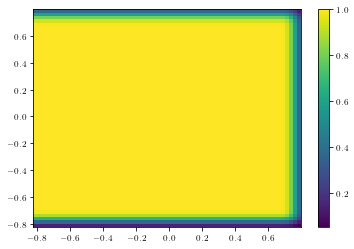

In [11]:
P.figure(1, facecolor='w')
P.pcolormesh(eta_grid,xi_grid,sigma_b)
P.colorbar()

In [12]:
def BC_E_metal_a():
    
    for i in range(0, NG + 1):        
        Er_a[i, :] = 0.0
        E2u_a[i, :] = 0.0
    for i in range(0, NG):        
        E1u_a[i, :] = 0.0

    for j in range(0, NG + 1):
        Er_a[:, j] = 0.0
        E1u_a[:, j] = 0.0
    for j in range(0, NG):        
        E2u_a[:, j] = 0.0

    for j in range(Neta + NG, Neta + 2 * NG):
        Er_a[:, j] = 0.0
        E1u_a[:, j] = 0.0
        E2u_a[:, j] = 0.0

def BC_B_metal_a():
    
    for i in range(0, NG + 1):   
        B1u_a[i, :] = 0.0
    for i in range(0, NG):
        Br_a[i, :] = 0.0
        B2u_a[i, :] = 0.0
        
    for j in range(0, NG + 1):
        B2u_a[:, j] = 0.0
    for j in range(0, NG):
        Br_a[:, j] = 0.0
        B1u_a[:, j] = 0.0
        
    for j in range(Neta + NG, Neta + 2 * NG):
        B2u_a[:, j] = 0.0
        Br_a[:, j] = 0.0
        B1u_a[:, j] = 0.0

def BC_E_metal_b():
        
    for i in range(Nxi + NG, Nxi + 2 * NG):
        Er_b[i, :] = 0.0
        E2u_b[i, :] = 0.0
        E1u_b[i, :] = 0.0

    for j in range(0, NG + 1):
        Er_b[:, j] = 0.0
        E1u_b[:, j] = 0.0
    for j in range(0, NG):        
        E2u_b[:, j] = 0.0

    for j in range(Neta + NG, Neta + 2 * NG):
        Er_b[:, j] = 0.0
        E1u_b[:, j] = 0.0
        E2u_b[:, j] = 0.0

def BC_B_metal_b():
    
    for i in range(Nxi + NG, Nxi + 2 * NG):
        B1u_b[i, :] = 0.0
        Br_b[i, :] = 0.0
        B2u_b[i, :] = 0.0
        
    for j in range(0, NG + 1):
        B2u_b[:, j] = 0.0
    for j in range(0, NG):
        Br_b[:, j] = 0.0
        B1u_b[:, j] = 0.0
        
    for j in range(Neta + NG, Neta + 2 * NG):
        B2u_b[:, j] = 0.0
        Br_b[:, j] = 0.0
        B1u_b[:, j] = 0.0

In [13]:
# Initial conditions

theta0, phi0 = 90.0 / 360.0 * 2.0 * N.pi, 70.0 / 360.0 * 2.0 * N.pi # Center of the wave packet
w = 0.1 # Radius of wave packet
amp = 0.2 # Maximal amplitude
wave = 1.0
J0 = 2.0
B0 = 0.0

def shape_packet(x, y, z, width):
    return amp * N.exp(- y * y / (width * width)) * N.exp(- x * x / (width * width)) * N.exp(- z * z / (width * width)) 

for i in range(Nxi + 2 * NG):
    for j in range(Neta + 2 * NG):
        
        X = N.tan(xi[i])
        Y = N.tan(eta[j])

        theta = 0.5 * N.pi - N.arctan(Y / N.sqrt(1.0 + X * X))
        phi = N.arctan2(1.0 / N.sqrt(1.0 + X * X), X / N.sqrt(1.0 + X * X))

        x = N.sin(theta) * N.cos(phi)
        y = N.sin(theta) * N.sin(phi)
        z = N.cos(theta)
        
        x0 = N.sin(theta0) * N.cos(phi0)
        y0 = N.sin(theta0) * N.sin(phi0)
        z0 = N.cos(theta0)
        
        Br0_a[i,j]  = 0.0 # shape_packet(x - x0, y - y0, z - z0, w) # * N.cos(2.0 * N.pi * eta[j] / wave)
        E2u0_a[i,j] = 0.0 # - shape_packet(x - x0, y - y0, z - z0, w) # * N.sin(2.0 * N.pi * eta[j] / wave)
        B1u0_a[i,j] = 0.0
        Er0_a[i,j]  = 0.0 
        E1u0_a[i,j] = 0.0
        B2u0_a[i,j] = 0.0
        
        Br0_b[i,j]  = 0.0
        E2u0_b[i,j] = 0.0
        B1u0_b[i,j] = 0.0
        Er0_b[i,j]  = 0.0 
        E1u0_b[i,j] = 0.0
        B2u0_b[i,j] = 0.0

def initialize_sim():
    
    Br_a[:,:]  = Br0_a[:,:]
    B1u_a[:,:] = B1u0_a[:,:]
    B2u_a[:,:] = B2u0_a[:,:]
    Er_a[:,:] = Er0_a[:,:]    
    E1u_a[:,:] = E1u0_a[:,:]
    E2u_a[:,:] = E2u0_a[:,:]

    Br_b[:,:] = Br0_b[:,:]
    B1u_b[:,:] = B1u0_b[:,:]
    B2u_b[:,:] = B2u0_b[:,:]
    Er_b[:,:] = Er0_b[:,:]
    E1u_b[:,:] = E1u0_b[:,:]
    E2u_b[:,:] = E2u0_b[:,:]

    B1d_a[:,:] = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
    B2d_a[:,:] = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
    E1d_a[:,:] = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
    E2d_a[:,:] = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
    
    B1d_b[:,:] = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
    B2d_b[:,:] = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
    E1d_b[:,:] = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
    E2d_b[:,:] = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))

In [14]:
def Jr_a(it, i, j):
    
    X = N.tan(xi[i])
    Y = N.tan(eta[j])

    theta = 0.5 * N.pi - N.arctan(Y / N.sqrt(1.0 + X * X))
    phi = N.arctan2(1.0 / N.sqrt(1.0 + X * X), X / N.sqrt(1.0 + X * X))

    x = N.sin(theta) * N.cos(phi)
    y = N.sin(theta) * N.sin(phi)
    z = N.cos(theta)
        
    x0 = N.sin(theta0) * N.cos(phi0)
    y0 = N.sin(theta0) * N.sin(phi0)
    z0 = N.cos(theta0)
        
    return J0 * N.sin(20.0 * dt * it) * shape_packet(x - x0, y - y0, z - z0, w) #shape_packet(xi[i], eta[j], 0.0, w)

def Jr_b(it, i, j):
    return 0.0

In [15]:
xi_tot = N.concatenate((xi_grid[NG:(Nxi + NG), NG:(Neta + NG)], xi_grid[NG:(Nxi + NG), NG:(Neta + NG)]), axis = 1)
eta_tot = N.concatenate((eta_grid[NG:(Nxi + NG), NG:(Neta + NG)], eta_grid[NG:(Nxi + NG), NG:(Neta + NG)] + N.pi / 2.0), axis = 1)
    
def plot_fields_plane(it, field):
    
    field_a = (globals()[field + "_a"])
    field_b = (globals()[field + "_b"])
    
    fig_size=deffigsize(2.0,0.7)
    ratio = 1.0

    fig = P.figure(1, facecolor = 'w')
    
    vm = 0.2 * amp
    
    ax  = P.subplot(121)
    ax.set_aspect(1.0/ax.get_data_ratio()*ratio)
    ax.pcolormesh(eta_grid[NG:(Nxi + NG), NG:(Neta + NG)], xi_grid[NG:(Nxi + NG), NG:(Neta + NG)], field_a[NG:(Nxi + NG), NG:(Neta + NG)], cmap = "RdBu_r", vmin = - vm, vmax = vm)
    # ax.pcolormesh(eta_grid, xi_grid, field_a, cmap = "RdBu_r", vmin = - amp, vmax = amp)
    ax.set_xlabel(r"$\xi_a$")
    ax.set_ylabel(r"$\eta$")
    ax.set_aspect(1.0/ax.get_data_ratio()*ratio)
        
    ax  = P.subplot(122)
    ax.set_aspect(1.0/ax.get_data_ratio()*ratio)
    f = ax.pcolormesh(eta_grid[NG:(Nxi + NG), NG:(Neta + NG)], xi_grid[NG:(Nxi + NG), NG:(Neta + NG)], field_b[NG:(Nxi + NG), NG:(Neta + NG)], cmap = "RdBu_r", vmin = - vm, vmax = vm)
    # f = ax.pcolormesh(eta_grid, xi_grid, field_b, cmap = "RdBu_r", vmin = - amp, vmax = amp)
    ax.set_xlabel(r"$\xi_b$")
    ax.set_yticklabels([])
    ax.yaxis.set_ticks_position('none') 
    ax.set_aspect(1.0/ax.get_data_ratio()*ratio)
        
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.2)
    # cbar=fig.colorbar(f,cax=cax)
    # cbar.ax.tick_params(labelsize=9)
    # cbar.ax.minorticks_off()
        
    P.subplots_adjust(wspace = 0, hspace=0)

    figsave_png("snapshots/" + field + "_" + str(it))
    
    P.close("all")

In [16]:
# Initialize simulation
initialize_sim()
iter = 0
idump = 0

In [17]:
Nt = 1500 # Number of iterations
FDUMP = 10 # Dump frequency

# Run the simulation
for it in range(Nt):
    if ((it % FDUMP) == 0):
        plot_fields_plane(idump,"Er")
        plot_fields_plane(idump,"B1u")
        plot_fields_plane(idump,"B2u")
        idump += 1

    print(it)
    iter += 1
    
    contra_to_cov_B_a()
    contra_to_cov_E_a()
    contra_to_cov_B_b()
    contra_to_cov_E_b()
    contra_to_cov_E_edge_a()
    contra_to_cov_B_edge_a()
    contra_to_cov_E_edge_b()
    contra_to_cov_B_edge_b()
    
    push_B_a()
    push_B_edge_a()
    BC_B_metal_a()
    BC_B_absorb_a()

    push_E_a(it)
    BC_E_metal_a()
    BC_E_absorb_a()

    push_B_b()
    BC_B_metal_b()
    BC_B_absorb_b()

    push_E_b(it)
    push_E_edge_b()
    BC_E_metal_b()
    BC_E_absorb_b()


0
interp B2d 0.0 0.0
1
interp B2d 0.0 0.0
2
interp B2d 0.0 0.0
3
interp B2d 2.988680969942894e-13 3.060739734542486e-13
4
interp B2d 1.195285285975657e-12 1.2241042806819142e-12
5
interp B2d 2.9903865017031052e-12 3.0624864011799983e-12
6
interp B2d 5.9904001242164565e-12 6.134832092634739e-12
7
interp B2d 1.0509317019448819e-11 1.076270279745825e-11
8
interp B2d 1.6871620167797824e-11 1.7278405098741122e-11
9
interp B2d 2.541510608565709e-11 2.6027880183351653e-11
10
interp B2d 3.649382956758509e-11 3.737371960043073e-11
11
interp B2d 5.048120377103488e-11 5.1698340109788223e-11
12
interp B2d 6.777328833354973e-11 6.94073510989187e-11
13
interp B2d 8.879229905734064e-11 9.093314891289466e-11
14
interp B2d 1.139903737226194e-10 1.1673877349278723e-10
15
interp B2d 1.4385362980450976e-10 1.4732206396118565e-10
16
interp B2d 1.7890655127545537e-10 1.8322015123465318e-10
17
interp B2d 2.1971674328356334e-10 2.250143273905321e-10
18
interp B2d 2.669000953161442e-10 2.7333533337848685e-10
1

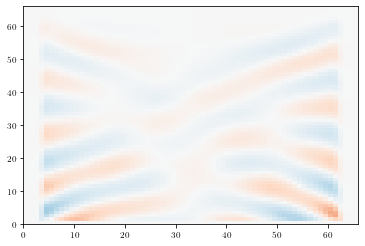

In [18]:
P.pcolormesh(B1u_b,vmin=-0.2,vmax=0.2,cmap="RdBu_r")